# Teste A/B
Luiz Guilherme Graciano Ribeiro Pereira

A atividade consiste em analisar dados de uma grande loja online. Junto com o departamento de marketing, foi compilado uma lista de hipóteses que podem ajudar a aumentar a receita.

É necessário priorizar essas hipóteses, lançar um teste A/B e analisar os resultados.

### Descrição dos dados

Dataframe contendo as hipóteses:

    Hypotheses — breves descrições das hipóteses
    Reach — alcance do usuário, em uma escala de um a dez
    Impact — impacto nos usuários, em uma escala de um a dez
    Confidence — confiança na hipótese, em uma escala de um a dez
    Effort — os recursos necessários para testar uma hipótese, em uma escala de um a dez. Quanto maior o valor de Effort, mais recursos são necessários para o teste.


Dataframe contendo as os pedidos dos usuários:

    transactionId — identificador do pedido
    visitorId — identificador do usuário que fez o pedido
    date — do pedido
    revenue — do pedido
    group — o grupo de teste A/B ao qual o usuário pertence


Dataframe contendo a quantidade de visitas por dia:

    date — data
    group — grupo de teste A/B
    visits — o número de visitas na data especificada para o grupo de teste A/B especificado

In [1]:
import pandas as pd
import matplotlib as plot
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats as st
pd.options.display.float_format = '{:.2f}'.format

## Pre-Processamento

### Importação do dataframe `hypotheses`:

In [2]:
try:
    hypotheses = pd.read_csv('hypotheses_us.csv', delimiter=';')
except:
    hypotheses = pd.read_csv('/datasets/hypotheses_us.csv', delimiter=';')

In [3]:
hypotheses.info()

hypotheses

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Effort      9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


,Hypothesis,Reach,Impact,Confidence,Effort
0,Add two new channels for attracting traffic. T...,3,10,8,6
1,Launch your own delivery service. This will sh...,2,5,4,10
2,Add product recommendation blocks to the store...,8,3,7,3
3,Change the category structure. This will incre...,8,3,3,8
4,Change the background color on the main page. ...,3,1,1,1
5,Add a customer review page. This will increase...,3,2,2,3
6,Show banners with current offers and sales on ...,5,3,8,3
7,Add a subscription form to all the main pages....,10,7,8,5
8,Launch a promotion that gives users discounts ...,1,9,9,5


O nome das colunas ficará em letra minúscula.

In [4]:
hypotheses.columns = hypotheses.columns.str.lower()

hypotheses.columns

Index(['hypothesis', 'reach', 'impact', 'confidence', 'effort'], dtype='object')

Não foram encontrados problemas no dataframe.

### Importação do dataframe `orders`:

In [5]:
try:
    orders = pd.read_csv('orders_us.csv', parse_dates=['date'])
except:
    orders = pd.read_csv('/datasets/orders_us.csv', parse_dates=['date'])

In [6]:
orders.info(memory_usage='deep')

orders.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   transactionId  1197 non-null   int64         
 1   visitorId      1197 non-null   int64         
 2   date           1197 non-null   datetime64[ns]
 3   revenue        1197 non-null   float64       
 4   group          1197 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 105.3 KB


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,30.40,B
1,2804400009,3642806036,2019-08-15,15.20,B
2,2961555356,4069496402,2019-08-15,10.20,A
3,3797467345,1196621759,2019-08-15,155.10,B
4,2282983706,2322279887,2019-08-15,40.50,B


In [7]:
orders.duplicated().value_counts()

False    1197
dtype: int64

Não foram encontrados linhas duplicadas.

In [8]:
orders['revenue'].describe()

count    1197.00
mean      131.49
std       603.00
min         5.00
25%        20.80
50%        50.20
75%       130.40
max     19920.40
Name: revenue, dtype: float64

Na coluna `revenue` parece haver valores extremos, eles serão investigados depois.

<div class="alert alert-success">
<strong>Comentário do revisor v1</strong>

Excelente trabalho checando a consistência dos dados.

Sempre importante para garantir uma análise robusta!
</div>


#### Indentificação de usuários que tenham entrado em ambos os grupos de teste:

In [9]:
ordersA = orders.query('group == "A"')
ordersB = orders.query('group == "B"')

ordersAB = orders.\
    query('visitorId in @ordersB["visitorId"] and visitorId in @ordersA["visitorId"]')\
    .sort_values(by=['visitorId','date'])

In [10]:
display(ordersAB.head())
ordersAB.describe()


,transactionId,visitorId,date,revenue,group
71,3679129301,8300375,2019-08-01,165.70,B
703,4293855558,8300375,2019-08-07,30.50,A
246,437656952,199603092,2019-08-02,55.70,B
1102,1941707234,199603092,2019-08-12,100.00,A
26,2223239646,199603092,2019-08-15,55.70,A


,transactionId,visitorId,revenue
count,181.00,181.00,181.00
mean,2158634383.61,2375242709.06,135.54
std,1202326358.54,1297837082.59,218.23
min,62794304.00,8300375.00,5.20
25%,1215730747.00,1404934699.00,25.50
50%,2213813903.00,2458001652.00,55.20
75%,3061324106.00,3717692402.00,130.80
max,4293855558.00,4266935830.00,1450.20


In [11]:
print('')
print('Porcentagem de linhas incorretas em relação ao total:')
print(len(ordersAB) / len(orders))

print('')
print('Porcentagem de usuários únicos incorretos em relação ao total:')
print(len(ordersAB['visitorId'].unique()) / len(orders['visitorId'].unique()))

print('')
print('Quantidade de usuários:')
print(len(ordersAB['visitorId'].unique()))


Porcentagem de linhas incorretas em relação ao total:
0.15121136173767752

Porcentagem de usuários únicos incorretos em relação ao total:
0.05625606207565471

Quantidade de usuários:
58


58 usuários entraram em ambos os grupos, eles fizeram compras em diferentes dias e entraram incorretamente em grupos diferentes, representam 5% dos usários. O número de compras de grupos errados foi de 181, representa 15% do dataframe total. Sendo assim, foi decidido pelo tratamento desses usuários.

#### Correção do usuários que tenhsm entrado em ambos os grupos de teste:

Para tratar esses dados, o primeiro grupo que o usuário entrou será aquele que ele ficará. Será identificado o grupo na primeira compra e as outras linhas serão modificadas para esse grupo.

In [12]:
ordersAB_min = ordersAB.groupby('visitorId').agg({'date':'min','group':'first'}).reset_index()

orders_clean = orders.copy()

grupo_map = dict(zip( ordersAB_min['visitorId'] , ordersAB_min['group']))

orders_clean['group']  = orders_clean['visitorId'].map(grupo_map)

orders_clean['group'] = orders_clean['group'].fillna(orders['group'])

orders_cleanA = orders_clean.query('group == "A"')
orders_cleanB = orders_clean.query('group == "B"')

orders_cleanAB = orders_clean.\
    query('visitorId in @orders_cleanB["visitorId"] and visitorId in @orders_cleanA["visitorId"]')\
    .sort_values(by=['visitorId','date'])

orders_cleanAB

,transactionId,visitorId,date,revenue,group


Não existem mais usuários em ambos os grupos.

### Importação do dataframe `visits`:

In [13]:
try:
    visits = pd.read_csv('visits_us.csv', parse_dates=['date'])
except:
    visits = pd.read_csv('/datasets/visits_us.csv', parse_dates=['date'])

In [14]:
visits.info(memory_usage='deep')

display(visits.head().sort_values(by='date'))

visits.tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    62 non-null     datetime64[ns]
 1   group   62 non-null     object        
 2   visits  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 4.6 KB


,date,group,visits
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


,date,group,visits
57,2019-08-27,B,720
58,2019-08-28,B,654
59,2019-08-29,B,531
60,2019-08-30,B,490
61,2019-08-31,B,718


Não foram encontrados problemas no dataframe.

## Priorizando Hipóteses

O dataframe `hypotheses` contém nove hipóteses para aumentar a receita de uma loja online com Reach, Impact, Confidence e Effort especificados para cada um. Será utilizado o framework ICE e RICE para priorizar hipóteses. 

In [15]:
hypotheses

,hypothesis,reach,impact,confidence,effort
0,Add two new channels for attracting traffic. T...,3,10,8,6
1,Launch your own delivery service. This will sh...,2,5,4,10
2,Add product recommendation blocks to the store...,8,3,7,3
3,Change the category structure. This will incre...,8,3,3,8
4,Change the background color on the main page. ...,3,1,1,1
5,Add a customer review page. This will increase...,3,2,2,3
6,Show banners with current offers and sales on ...,5,3,8,3
7,Add a subscription form to all the main pages....,10,7,8,5
8,Launch a promotion that gives users discounts ...,1,9,9,5


### Cálculo do ICE e RICE:

In [16]:
hypotheses['RICE'] = (hypotheses['impact'] * hypotheses['confidence'] * hypotheses['reach'] ) / hypotheses['effort']

hypotheses['ICE'] = (hypotheses['impact'] * hypotheses['confidence']) / hypotheses['effort']

display(hypotheses[['hypothesis','ICE']].sort_values(by='ICE', ascending=False).head())

display(hypotheses[['hypothesis','RICE']].sort_values(by='RICE', ascending=False).head())

,hypothesis,ICE
8,Launch a promotion that gives users discounts ...,16.20
0,Add two new channels for attracting traffic. T...,13.33
7,Add a subscription form to all the main pages....,11.20
6,Show banners with current offers and sales on ...,8.00
2,Add product recommendation blocks to the store...,7.00


,hypothesis,RICE
7,Add a subscription form to all the main pages....,112.00
2,Add product recommendation blocks to the store...,56.00
0,Add two new channels for attracting traffic. T...,40.00
6,Show banners with current offers and sales on ...,40.00
8,Launch a promotion that gives users discounts ...,16.20


In [17]:
hypo_table = hypotheses.pivot_table(index ='hypothesis', values=['ICE','RICE'])\
            .sort_values(by='RICE', ascending=False)\
            .head().reset_index()

hypo_table

,hypothesis,ICE,RICE
0,Add a subscription form to all the main pages....,11.20,112.00
1,Add product recommendation blocks to the store...,7.00,56.00
2,Add two new channels for attracting traffic. T...,13.33,40.00
3,Show banners with current offers and sales on ...,8.00,40.00
4,Launch a promotion that gives users discounts ...,16.20,16.20


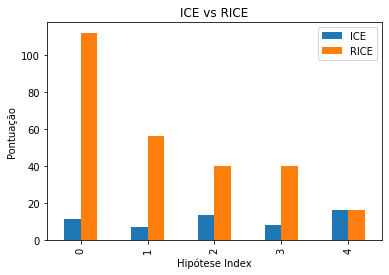

,index,hypothesis
0,0,Add a subscription form to all the main pages....
1,1,Add product recommendation blocks to the store...
2,2,Add two new channels for attracting traffic. T...
3,3,Show banners with current offers and sales on ...
4,4,Launch a promotion that gives users discounts ...


In [18]:
hypo_table.reset_index(inplace=True)
hypo_table.plot(x='index', y=['ICE','RICE'], kind='bar')
plt.title('ICE vs RICE')
plt.xlabel('Hipótese Index')
plt.ylabel('Pontuação')
plt.legend()
plt.show()

display(hypo_table[['index','hypothesis']])

In [19]:
hypo_table['hypothesis'].tolist()

['Add a subscription form to all the main pages. This will help you compile a mailing list',
 "Add product recommendation blocks to the store's site. This will increase conversion and average purchase size",
 'Add two new channels for attracting traffic. This will bring 30% more users',
 'Show banners with current offers and sales on the main page. This will boost conversion',
 'Launch a promotion that gives users discounts on their birthdays']

Pelo metódo RICE foi identificado que as três principais hipóteses que devem ser testadas são:
- Add a subscription form to all the main pages. This will help you compile a mailing list.
- Add product recommendation blocks to the store's site. This will increase conversion and average purchase size.
- Add two new channels for attracting traffic. This will bring 30% more users. 

Essas três foram relevantes no metódo ICE e são as que possuem maior alcance.

## Análise de teste A/B

Para analisar a diferença de receita, conversão e tamanho médio do pedido entre o grupa A e B, os dataframes serão agregados e serão cumulativos, pois métricas cumulativa tendem a convergir e se agrupar em torno de uma média específica.

In [20]:
# construindo um vetor com valores de pares unívocos de grupos de datas
datesGroups = orders_clean[['date','group']].drop_duplicates()

# obtendo dados diários cumulativos agregados sobre pedidos 
orders_cleanAggregated = datesGroups\
    .apply(lambda x: orders_clean[np.logical_and(orders_clean['date'] <= x['date'], orders_clean['group'] == x['group'])]\
    .agg({'date' : 'max', 'group' : 'max', 'transactionId' : pd.Series.nunique,\
          'visitorId' : pd.Series.nunique, 'revenue' : 'sum'}), axis=1)\
    .sort_values(by=['date','group'])

# obtendo dados diários cumulativos agregados sobre visitantes  
visitsAggregated = datesGroups\
    .apply(lambda x: visits[np.logical_and(visits['date'] <= x['date'], visits['group'] == x['group'])]\
    .agg({'date' : 'max', 'group' : 'max', 'visits' : 'sum'}), axis=1)\
    .sort_values(by=['date','group'])

# juntando as duas tabelas em uma e dando nomes descritivos para suas colunas
cumulativeData = orders_cleanAggregated.merge(visitsAggregated, left_on=['date', 'group'],\
                                        right_on=['date', 'group'])

cumulativeData.columns = ['date', 'group', 'orders_clean', 'buyers', 'revenue', 'visits']

# Calculo do tamanho medio do pedido
cumulativeData['mean_vol'] = cumulativeData['revenue'] /  cumulativeData['orders_clean']

# Calculo da conversão 
cumulativeData['conversion'] = cumulativeData['orders_clean'] /  cumulativeData['visits']

display(cumulativeData.head(5)) 

,date,group,orders_clean,buyers,revenue,visits,mean_vol,conversion
0,2019-08-01,A,24,20,2356.80,719,98.20,0.03
1,2019-08-01,B,21,20,1620.00,713,77.14,0.03
2,2019-08-02,A,43,37,3825.10,1338,88.96,0.03
3,2019-08-02,B,46,43,4279.00,1294,93.02,0.04
4,2019-08-03,A,67,61,5640.30,1845,84.18,0.04


In [21]:
# DataFrame com pedidos cumulativos e receita cumulativa por dia, grupo A
cumulativeA = cumulativeData.query('group == "A"')

# DataFrame com pedidos cumulativos e receita cumulativa por dia, grupo B
cumulativeB = cumulativeData.query('group == "B"')

# reunindo os dados em um DataFrame
mergedCumulative = cumulativeA.merge(cumulativeB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
mergedCumulative.head()

,date,groupA,orders_cleanA,buyersA,revenueA,visitsA,mean_volA,conversionA,groupB,orders_cleanB,buyersB,revenueB,visitsB,mean_volB,conversionB
0,2019-08-01,A,24,20,2356.80,719,98.20,0.03,B,21,20,1620.00,713,77.14,0.03
1,2019-08-02,A,43,37,3825.10,1338,88.96,0.03,B,46,43,4279.00,1294,93.02,0.04
2,2019-08-03,A,67,61,5640.30,1845,84.18,0.04,B,62,59,6085.80,1803,98.16,0.03
3,2019-08-04,A,79,73,6326.00,2562,80.08,0.03,B,83,75,8264.00,2573,99.57,0.03
4,2019-08-05,A,103,95,8119.30,3318,78.83,0.03,B,107,97,9953.80,3280,93.03,0.03


In [22]:
def plot_ax(title, x, y, relative= False, legend = True, axis =False):
    plt.title(title)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.xticks(rotation=45)
    if legend == True:
        plt.legend()
    if relative == True:
        plt.axhline(y=0, color='black', linestyle='--')
    if axis == True:
        plt.axis([pd.to_datetime('2019-08-01'), pd.to_datetime('2019-09-01'), 0, 0.05])
    plt.show()

### Gráfico da receita acumulada por grupo. 

Será anlisado a receita entre os dois grupos:

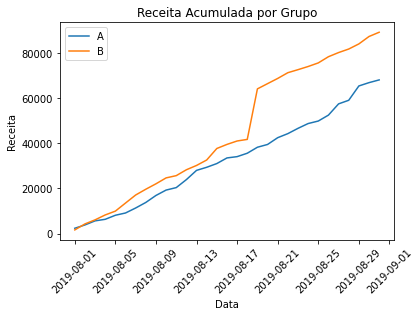

In [23]:
# construindo o gráfico de receita do grupo A 
plt.plot(mergedCumulative['date'], mergedCumulative['revenueA'], label='A')

# construindo o gráfico de receita do grupo B 
plt.plot(mergedCumulative['date'], mergedCumulative['revenueB'], label='B')

plot_ax('Receita Acumulada por Grupo','Data','Receita')

O gráfico demonstra que a receita de B foi melhor que a receita de A, mas houve uma disparada da receita em B, o que pode significar valores extremos no grupo. Sendo assim, é necessário filtrar os dados para ter uma analise mais sólida.

### Gráfico do tamanho médio acumulado do pedido por grupo.

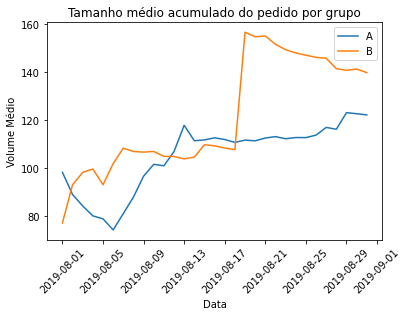

In [24]:
plt.plot(mergedCumulative['date'], mergedCumulative['mean_volA'], label='A')
plt.plot(mergedCumulative['date'], mergedCumulative['mean_volB'], label='B')

plot_ax('Tamanho médio acumulado do pedido por grupo','Data','Volume Médio')

Em relação ao volume médio, o grupo A e B mudaram de posição mais de uma vez, com o grupo B performando melhor no final mas em tendência de queda, o grupo A parece ter estabilizado. Nesse gráfico também é possível -identificar valores extremos no grupo B.

### Gráfico da diferença relativa no tamanho médio acumulado do pedido para o grupo B em comparação com o grupo A. 

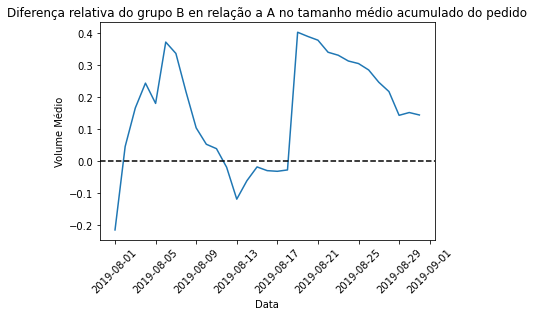

In [25]:
# construindo um gráfico de diferença relativa para os volumes médios de compra
plt.plot(mergedCumulative['date'], (mergedCumulative['mean_volB'])/(mergedCumulative['mean_volA'])-1)

# acrescentando o eixo X
plot_ax('Diferença relativa do grupo B en relação a A no tamanho médio acumulado do pedido','Data','Volume Médio', True, False)

Pela diferença relativa não podemos dizer que o valor tenha de B tenha estabilizado, ele teve vários picos e quedas, chegando a ser 40% melhor que A, valores extremos o estão afetando, após o pico o grupo B está em tendencia de queda.

### Gráfico da taxa de conversão de cada grupo como a proporção de pedidos para o número de visitas para cada dia. 

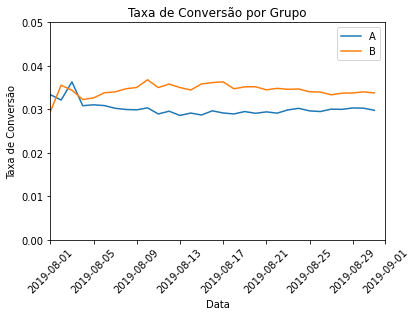

In [26]:
plt.plot(mergedCumulative['date'], mergedCumulative['conversionA'], label='A')
plt.plot(mergedCumulative['date'], mergedCumulative['conversionB'], label='B')

plot_ax('Taxa de Conversão por Grupo','Data','Taxa de Conversão', relative= False, legend = True, axis =True)

A taxa de conversão entre os dois grupos parece ter estabilizado, com o grupo B sendo melhor que o grupo A. È necessário um teste estatístico para comprovar. 

### Gráfico da diferença relativa na conversão cumulativa para o grupo B em comparação com o grupo A. 

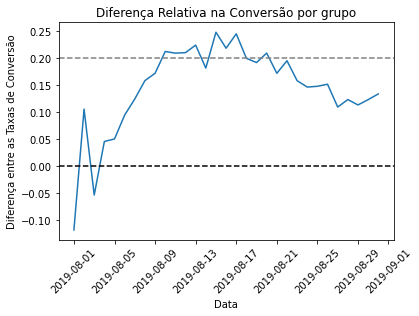

In [27]:
# construindo um gráfico de diferença relativa para as conversões
plt.plot(mergedCumulative['date'], (mergedCumulative['conversionB'])/(mergedCumulative['conversionA'])-1)

# acrescentando o eixo X
plt.axhline(y=0.2, color='grey', linestyle='--')
(plot_ax('Diferença Relativa na Conversão por grupo','Data','Diferença entre as Taxas de Conversão',
         relative= True, legend = False, axis =False))

Pelo gráfico da diferença relativa, podemos ver que o grupo B chegou a ter uma conversão 25% do que A, com as conversões estabilizada e uma diferença de 20% são indícios for tes que B foi melhor que A.

### Calculo dos percentis 90, 95 e 99 para o número de pedidos por usuário. Definido o ponto em que um ponto de dados se torna uma anomalia.

In [28]:
transaction_quant= orders_clean.groupby('visitorId', as_index=False).agg({'transactionId': pd.Series.nunique})

transaction_quant.columns = ['visitorId', 'transaction']

t_quant = transaction_quant['transaction'].value_counts()

display(t_quant)
print('Percentis 90, 95 e 99:')
print(np.percentile(transaction_quant['transaction'], [90, 95,99]))


1     937
2      64
3      17
5       6
4       3
11      2
8       1
9       1
Name: transaction, dtype: int64

Percentis 90, 95 e 99:
[1. 2. 4.]


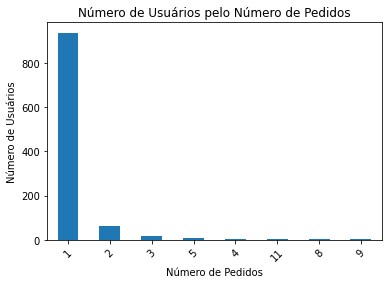

In [29]:
t_quant.plot(x=0, y=1, kind='bar')
(plot_ax('Número de Usuários pelo Número de Pedidos','Número de Pedidos','Número de Usuários',
         relative= False, legend = False, axis =False))

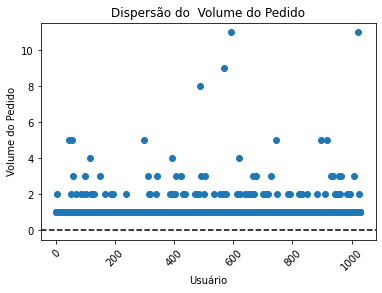

In [30]:
x_values = pd.Series(range(0,len(transaction_quant['transaction'])))
plt.scatter(x_values, transaction_quant['transaction'])
(plot_ax('Dispersão do  Volume do Pedido','Usuário','Volume do Pedido',
         relative= True, legend = False, axis =False))


Menos de 5% dos dados tem mais do que dois pedidos e menos de 1% tem mais de 4, sendo assim, decidi que acima de dois pedidos pode ser considerado uma anomalia.

### Calcule os percentis 90, 95 e 99 dos preços dos pedidos e gráfico de dispersão dos preços dos pedidos. 

In [31]:
display(orders_clean['revenue'].describe())
print('Percentis 90, 95 e 99:')
print(np.percentile(orders['revenue'], [90, 95,99]))

count    1197.00
mean      131.49
std       603.00
min         5.00
25%        20.80
50%        50.20
75%       130.40
max     19920.40
Name: revenue, dtype: float64

Percentis 90, 95 e 99:
[282.48  435.54  900.904]


In [32]:
orders_clean.query('revenue > 19000')

,transactionId,visitorId,date,revenue,group
425,590470918,1920142716,2019-08-19,19920.40,B


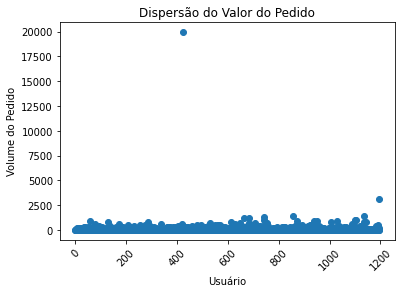

In [33]:
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.scatter(x_values, orders_clean['revenue'])
(plot_ax('Dispersão do Valor do Pedido','Usuário','Volume do Pedido',
         relative= False, legend = False, axis =False))


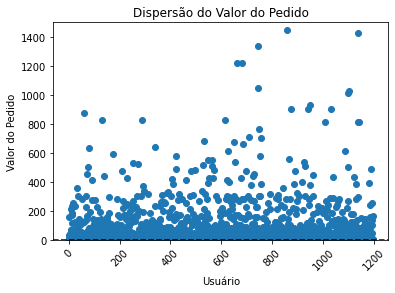

In [34]:
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.scatter(x_values, orders_clean['revenue'])
plt.ylim(0, 1500)
(plot_ax('Dispersão do Valor do Pedido','Usuário','Valor do Pedido',
         relative= True, legend = False, axis =False))


Em relação ao valor do pedido, menos de 5% dos pedidos teve um valor maior que 435. Com um único pedido no valor de 20.000 no grupo B, o que é a causa dos picos em receita e volume médio, distorcendo esse grupo. Sendo assim, irei considerar apenas valores abaixo. de 435.

### Encontrando a significância estatística da diferença na conversão entre os grupos usando os dados brutos. 

Agora identificarei se a diferença entre as conversões A e B são estatísticamente significativas.

Separando os grupos e preparando o teste estatístico:

In [35]:
ordersByUsersA = orders_clean.query('group == "A"').groupby('visitorId', as_index=False)\
                .agg({'transactionId' : pd.Series.nunique})


ordersByUsersB = orders_clean.query('group == "B"').groupby('visitorId', as_index=False)\
                .agg({'transactionId' : pd.Series.nunique})

ordersByUsersB.columns = ['visitorId', 'transactionId']

sampleA =(pd.concat([ordersByUsersA['transactionId'],
                     pd.Series(0, index=np.arange(visits.query('group == "A"')['visits'].sum() - 
                                                  len(ordersByUsersA['transactionId'])), name='transactionId')],axis=0))

sampleB = (pd.concat([ordersByUsersB['transactionId'],
                      pd.Series(0, index=np.arange(visits.query('group == "B"')['visits'].sum() - 
                                  len(ordersByUsersB['transactionId'])), name='transactionId')],axis=0))

Teste de Shapiro-Will para identificar se os dados se distribuem de forma normal:

In [36]:
alpha = .05 # nível de significância


results = st.shapiro(ordersByUsersA['transactionId'])
p_value = results[1] # o segundo valor no vetor de resultados (com índice 1) - o valor-p

print('p-value: ', p_value)

if (p_value < alpha):
    print("A - Hipótese nula rejeitada: a distribuição não é normal")
else:
    print("A - Falha ao rejeitar a hipótese nula: a distribuição parece ser normal")
    
results = st.shapiro(ordersByUsersB['transactionId'])
p_value = results[1] # o segundo valor no vetor de resultados (com índice 1) - o valor-p

print('p-value: ', p_value)

if (p_value < alpha):
    print("B - Hipótese nula rejeitada: a distribuição não é normal")
else:
    print("B - Falha ao rejeitar a hipótese nula: a distribuição parece ser normal") 

p-value:  2.311063466318418e-40
A - Hipótese nula rejeitada: a distribuição não é normal
p-value:  1.2401491409274631e-42
B - Hipótese nula rejeitada: a distribuição não é normal


As conversões dos grupos A e B **não** estão distribuidos normalmente. 

Será utilizado o teste Não-Paramétrico Wilcoxon-Mann-Whitney, para distribuições não normais:

In [37]:
print('valor-p:')
print("{0:.5f}".format(st.mannwhitneyu(sampleA, sampleB)[1]))
print('')

print('Diferença relativa de B sobre A:')
print("{0:.3f}".format(sampleB.mean()/sampleA.mean()-1)) 

valor-p:
0.01665

Diferença relativa de B sobre A:
0.134


A diferença entre as conversões é estatísticamente significativa para os dados brutos. Com as conversões do grupo B sendo 13% maiores.

### Encontrando a significância estatística da diferença no tamanho médio do pedido entre os grupos usando os dados brutos. 

Identificarei se a diferença no tamanho médio do pedido entre os grupos A e B é estatísticamente significativa.

Teste de Shapiro-Will para identificar se os dados se distribuem de forma normal:

In [38]:
alpha = .05 # nível de significância


results = st.shapiro(orders_clean.query('group == "A"')['revenue'])
p_value = results[1] # o segundo valor no vetor de resultados (com índice 1) - o valor-p

print('p-value: ', p_value)

if (p_value < alpha):
    print("A - Hipótese nula rejeitada: a distribuição não é normal")
else:
    print("A - Falha ao rejeitar a hipótese nula: a distribuição parece ser normal")
    
results = st.shapiro(orders_clean.query('group == "B"')['revenue'])
p_value = results[1] # o segundo valor no vetor de resultados (com índice 1) - o valor-p

print('p-value: ', p_value)

if (p_value < alpha):
    print("B - Hipótese nula rejeitada: a distribuição não é normal")
else:
    print("B - Falha ao rejeitar a hipótese nula: a distribuição parece ser normal") 

p-value:  2.0748701295887084e-34
A - Hipótese nula rejeitada: a distribuição não é normal
p-value:  0.0
B - Hipótese nula rejeitada: a distribuição não é normal


Os dados da diferença no tamanho médio do pedido dos grupos A e B **não** estão distribuidos normalmente. 

Será utilizado o teste Não-Paramétrico Wilcoxon-Mann-Whitney, para distribuições não normais:

In [39]:
print('valor-p:')
(print('{0:.3f}'
       .format(st.mannwhitneyu(orders_clean.query('group == "A"')['revenue'], 
                    orders_clean.query('group == "B"')['revenue'])[1])))

print('')

print('Diferença relativa de B sobre A:')
(print('{0:.3f}'
       .format(orders_clean.query('group == "B"')['revenue'].mean()/
               orders_clean.query('group == "A"')['revenue'].mean()-1)))


valor-p:
0.409

Diferença relativa de B sobre A:
0.144


A diferença entre  os tamanhos médios dos pedidos **não** é estatísticamente significativa para os dados brutos. Não é possível dizer que são diferentes.
Com as conversões do grupo B sendo 14% maiores.

### Encontrando a significância estatística da diferença na conversão entre os grupos usando os dados filtrados.

agora irei filtrar os dados para a retirada de valores extremos, com mais que dois pedidos ou pedidos acima do valor de 435.54 sendo considerados anomalias e retirados da amostra. Os testes estatísticos serão refeitos com os dados filtrados.

Lista dos dados anômalos:

In [40]:
usersWithManyOrders = (pd.concat([ordersByUsersA[ordersByUsersA['transactionId'] > 2]['visitorId'], 
                                  ordersByUsersB[ordersByUsersB['transactionId'] > 2]['visitorId']], axis = 0))

usersWithExpensiveOrders = orders_clean[orders_clean['revenue'] > 435.54]['visitorId']

abnormalUsers = pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis = 0).drop_duplicates().sort_values()

print(abnormalUsers.head(5))
print(abnormalUsers.shape) 

1099    148427295
27      199603092
928     204675465
20      237748145
36      249864742
Name: visitorId, dtype: int64
(83,)


Filtagem da amostra:

In [41]:
sampleAFiltered = (pd.concat([ordersByUsersA[np.logical_not(ordersByUsersA['visitorId'].isin(abnormalUsers))]['transactionId'],
                              pd.Series(0, index=np.arange(visits.query('group == "A"')['visits'].sum() - 
                                                           len(ordersByUsersA['transactionId'])),name='transactionId')],axis=0))



sampleBFiltered = (pd.concat([ordersByUsersB[np.logical_not(ordersByUsersB['visitorId'].isin(abnormalUsers))]['transactionId'],
                              pd.Series(0, index=np.arange(visits.query('group == "B"')['visits'].sum() - 
                                                           len(ordersByUsersB['transactionId'])),name='transactionId')],axis=0))


Teste Wilcoxon-Mann-Whitney, para a diferença entre as conversões:

In [42]:
print('valor-p:')
print("{0:.5f}".format(st.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print('')

print('Diferença relativa de B sobre A:')
print("{0:.3f}".format(sampleBFiltered.mean()/sampleAFiltered.mean()-1))

valor-p:
0.01574

Diferença relativa de B sobre A:
0.157


Com os dados filtrados a diferença entre as conversões continua estatísticamente significativa. O valor-p diminuiu e a conversão do grupo B aumentou para 15% maior em relação ao grupo A.

Sendo assim, temos provas estatísticas suficientes para dizer que os grupo B é melhor que o grupo A em conversões.

### Encontrando a significância estatística da diferença no tamanho médio do pedido entre os grupos usando os dados filtrados. 

Teste Wilcoxon-Mann-Whitney, para a diferença entre os tamanhos médios dos pedidos entre os grupos:

In [43]:
print('valor-p:')
print('{0:.3f}'.format(st.mannwhitneyu(
    orders_clean[np.logical_and(
        orders_clean['group']=='A',
        np.logical_not(orders_clean['visitorId'].isin(abnormalUsers)))]['revenue'],
    orders_clean[np.logical_and(
        orders_clean['group']=='B',
        np.logical_not(orders_clean['visitorId'].isin(abnormalUsers)))]['revenue'])[1]))

print('')

print('Diferença relativa de B sobre A:')
print('{0:.3f}'.format(
     orders_clean[np.logical_and(
         orders_clean['group']=='B',
         np.logical_not(orders_clean['visitorId'].isin(abnormalUsers)))]['revenue'].mean()
    /orders_clean[np.logical_and(
        orders_clean['group']=='A',
        np.logical_not(orders_clean['visitorId'].isin(abnormalUsers)))]['revenue'].mean() - 1)) 

valor-p:
0.447

Diferença relativa de B sobre A:
-0.055


Com os dados filtrados a diferença entre os tamanhos médios dos pedidos continua **não** sendo estatísticamente significativa. Não é possível dizer que são diferentes.

Sendo assim, não podemos é possivel identificar uma diferença entre os tamanhos médios dos pedidos.

## Conclusão

### Hipósteses

As hipóteses que devem ser testadas primeiro pelo framework RICE são:


    Add a subscription form to all the main pages. This will help you compile a mailing list.
    Add product recommendation blocks to the store's site. This will increase conversion and average purchase size.
    Add two new channels for attracting traffic. This will bring 30% more users.


### Teste A/B

#### Conversão 

Em relação a conversão, podemos afirmar que o grupo B foi 15% melhor que o grupo A. Com a metríca já estabilizada, podemos afirmar que o grupo B foi estatisticamente melhor.  

#### Receita

Em relação a receita, não podemos afirmar que houve diferença entre os grupos. A metríca continua flutuando mas ela não indica que pode estabilizar-se, logo, podemos dizer que não houve diferença estatística na receita.

#### Resultado do teste

A partir da análise, aconselho a parada do teste. O grupo B foi melhor em conversões, sendo o mais indicado para a escolha, não houve grupo melhor em relação a receita.